In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
#!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
%cd /content/
# install detectron2:
!git clone https://github.com/facebookresearch/detectron2
%cd /content/detectron2
# !pip install -r requirements.txt
!python setup.py install
!pip install git+https://github.com/facebookresearch/fvcore.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-uwuqh65w
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-uwuqh65w
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
2.0.0+cu118 True
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/content
fatal: destination path 'detectron2' already exists and is not an empty directory.
/content/detectron2
running install
/usr/local/lib/python3.9/dist-packages/setuptools/command

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import Resize
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.nn as nn
import torchvision
import torch
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog
from detectron2.data import transforms as T
from detectron2.structures import BoxMode
from detectron2.modeling import build_model
from PIL import Image, ImageDraw
from scipy.optimize import linear_sum_assignment
import numpy as np
import cv2


# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# # import some common libraries
# import numpy as np
# import cv2
# import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

from tqdm import tqdm
import matplotlib.pyplot as plt 

In [5]:
def xyxy_to_cxcywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    return int(x), int(y), int(w), int(h)

def cxcywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    return int(xmin), int(ymin), int(xmax), int(ymax)

In [6]:
class PoolDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(PoolDetectionModel, self).__init__()

        # num_predictions = 10
        
        # Cargamos el modelo pre-entrenado
        self.model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True)

        # Cambiamos el número de clases de salida
        hidden_dim = self.model.transformer.d_model
        self.model.num_classes = num_classes
        self.model.class_embed = nn.Linear(hidden_dim, num_classes)
        
        # Cambiamos el número predicciones
        # num_query = self.model.transformer.d_model
        # self.model.query_embed = nn.Embedding(num_predictions, num_query)
        
    def forward(self, x):
        # Pasamos las imágenes por el modelo pre-entrenado
        outputs = self.model(x)
        
        # Obtenemos las cajas y las etiquetas de las predicciones
        boxes = outputs['pred_boxes']
        labels = outputs['pred_logits'].sigmoid()
        
        # Devolvemos las cajas y las etiquetas
        return boxes, labels

In [28]:
def hungarian_loss_2(outputs, targets):
    boxes, labels = outputs
    true_boxes = torch.FloatTensor(targets['boxes']).to(device)
    true_labels = torch.FloatTensor(targets['labels']).to(device)
    true_labels = torch.FloatTensor([[label] for label in true_labels]).to(device)

    true_labels_0s = true_labels.flatten()
    true_labels_0s = torch.cat((true_labels_0s, torch.zeros(100-len(true_labels_0s)).to(device)), 0)

    # Calculamos la entropía cruzada binaria para todas las etiquetas
    all_label_loss = F.binary_cross_entropy(labels.flatten(), true_labels_0s)

    # Calculamos el costo de emparejamiento entre las cajas predichas y verdaderas
    cost_boxes = torch.cdist(boxes, true_boxes, p=1)
    
    # Calculamos el costo de emparejamiento entre las etiquetas predichas y verdaderas
    cost_labels = torch.cdist(labels, true_labels, p=1)
    
    # Combinamos los costos
    cost = cost_boxes + cost_labels
    
    # Resolvemos el problema de asignación lineal
    row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())
    
    # Obtenemos las cajas y etiquetas predichas emparejadas
    boxes = boxes[row_ind]
    labels = labels[row_ind]
    
    # Obtenemos las cajas y etiquetas verdaderas emparejadas
    true_boxes = true_boxes[col_ind]
    true_labels = true_labels[col_ind]

    # Calculamos la pérdida de IoU para las cajas
    box_loss = F.mse_loss(boxes, true_boxes)
    
    # Calculamos la entropía cruzada binaria para las etiquetas emparejadas
    label_loss = F.binary_cross_entropy(labels, true_labels)
    
    # Combinamos las pérdidas
    loss = box_loss*100 + label_loss*10 + all_label_loss

    # print(loss.item(), box_loss.item(), label_loss.item(), all_label_loss.item())
    
    return loss

In [29]:
def hungarian_loss(outputs, targets):
    boxes, labels = outputs
    true_boxes, true_labels = torch.FloatTensor(targets['boxes']).to(device), torch.FloatTensor(targets['labels']).to(device)
    true_labels = torch.FloatTensor([[label] for label in true_labels]).to(device)

    # Calculamos el costo de emparejamiento entre las cajas predichas y verdaderas
    cost_boxes = torch.cdist(boxes, true_boxes, p=1)
    
    # Calculamos el costo de emparejamiento entre las etiquetas predichas y verdaderas
    cost_labels = torch.cdist(labels, true_labels, p=1)
    
    # Combinamos los costos
    cost = cost_boxes + cost_labels
    
    # Resolvemos el problema de asignación lineal
    row_ind, col_ind = linear_sum_assignment(cost.cpu().detach().numpy())
    
    # Obtenemos las cajas y etiquetas predichas emparejadas
    boxes = boxes[row_ind]
    labels = labels[row_ind]
    
    # Obtenemos las cajas y etiquetas verdaderas emparejadas
    true_boxes = true_boxes[col_ind]
    true_labels = true_labels[col_ind]

    # Calculamos la pérdida de IoU para las cajas
    box_loss = F.mse_loss(boxes, true_boxes)
    
    # Calculamos la entropía cruzada binaria para las etiquetas
    label_loss = F.binary_cross_entropy(labels, true_labels)
    
    # Combinamos las pérdidas
    loss = box_loss + label_loss
    
    return loss

In [30]:
def object_detection_loss(output, target):
    bbox_pred = torch.squeeze(output[0])
    prob_pred = torch.squeeze(output[1])

    bbox_true = torch.FloatTensor([t["boxes"][0] for t in target]).to(device)

    # prob_true = torch.FloatTensor([label for t in target for label in t["labels"]]).to(device)
    prob_true = torch.FloatTensor([t["labels"][0] for t in target]).to(device)


    # Calcula la pérdida de entropía cruzada con pesos para la clasificación
    classification_loss = F.binary_cross_entropy(prob_pred, prob_true)

    # Recorte provisional de las bbtrue
    

    # Calcula la pérdida de error cuadrático medio para la regresión
    regression_loss = F.mse_loss(bbox_pred, bbox_true)

    # Combina las pérdidas de clasificación y regresión
    loss = classification_loss + regression_loss

    return loss

In [1]:
def collate_fn(batch):
    images = []
    targets = []
    transform = Resize(new_size)
    for sample in batch:
        image = Image.open(sample['file_name']).convert('RGB')
        width, height = image.size
        # Transformar la imagen
        image = transform(image)
        # Adaptar las anotaciones
        annotations = sample['annotations']
        for ann in annotations:
            bbox = ann['bbox']
            x_original, y_original, w_original, h_original = bbox
            x_new = x_original / width #* new_size[1]
            y_new = y_original / height #* new_size[0]
            w_new = w_original / width #* new_size[1]
            h_new = h_original / height #* new_size[0]
            ann['bbox'] = [x_new, y_new, w_new, h_new]
            # print(bbox)
            # print(ann['bbox'])
        
        # Añadir la imagen y las anotaciones a la lista
        images.append(image)
        targets.append({'boxes': [ann['bbox'] for ann in annotations], 'labels': [1 for ann in annotations if ann['category_id'] == 0]})
        targets[-1]['boxes'].append([0.1, 0.1, 0.1, 0.1])
        targets[-1]['labels'].append(0)
    return images, targets

In [2]:
def train(model, optimizer, data_loader, device, epochs=10):
    model.train()
    losses = []
    min_loss = 100000000000

    for name, param in model.named_parameters():
        if "query_embed" not in name and "bbox_embed" not in name:
            param.requires_grad = False
        else:
          print("No congelando:", name)
    for epoch in range(epochs):
      print("\nEpoch:", epoch, "\n")
      for images, targets in tqdm(data_loader):
          images = [TF.to_tensor(image).to(device) for image in images]
          targets = [{k: v for k, v in t.items()} for t in targets]
          output = model(images)
          loss = 0
          output = [(prob, targ) for prob, targ in zip(output[0], output[1])]
          for o, t in zip(output, targets):
            loss += hungarian_loss(o, t)
            # print(o)
            # print(t)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # losses = object_detection_loss(output, targets)
          loss = loss.item()/len(images)
          print(" - loss:", loss)
          losses.append(loss)
          # if min_loss > loss.item():
          #   min_loss = loss.item()
          #   print("Save best model", loss.item())
          #   torch.save(model, "/content/drive/MyDrive/TFG_999/model_best.pt")
          if len(losses) > 2 and abs(losses[-1] - losses[-2]) < 0.0001:
            return losses
    return losses

In [3]:
path_dataset = "/content/drive/MyDrive/TFG_999/dataset_700x700/"
paramaters = {"learning_rate": 0.01,
              "momentum": 0.9,
              "batch_size": 32,
              "epochs": 10}

new_size = (700, 700)


DatasetCatalog.clear()
MetadataCatalog.clear()

# Declarar el modelo
model = PoolDetectionModel(num_classes=1)

# Declarar el optimizador
optimizer = optim.SGD(model.parameters(), lr=paramaters["learning_rate"], momentum=paramaters["momentum"])

# Registrar instancia de COCO
register_coco_instances("piscinas_entrenamiento", {}, f"{path_dataset}annotations_train.json", f"{path_dataset}images")

# Cargar la instancia de COCO como un objeto Dataset
dataset_name = "piscinas_entrenamiento"
dataset = DatasetCatalog.get(dataset_name)

# Obtener metadatos del dataset
metadata = MetadataCatalog.get(dataset_name)

# Declarar el DataLoader
data_loader = DataLoader(dataset, batch_size=paramaters["batch_size"], shuffle=True, collate_fn=collate_fn)

# Declarar el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover el modelo y el DataLoader al dispositivo
model.to(device)
train_loss = train(model, optimizer, data_loader, device, epochs = paramaters["epochs"])

NameError: ignored

{'learning_rate': 0.01, 'momentum': 0.9, 'batch_size': 32, 'epochs': 10}


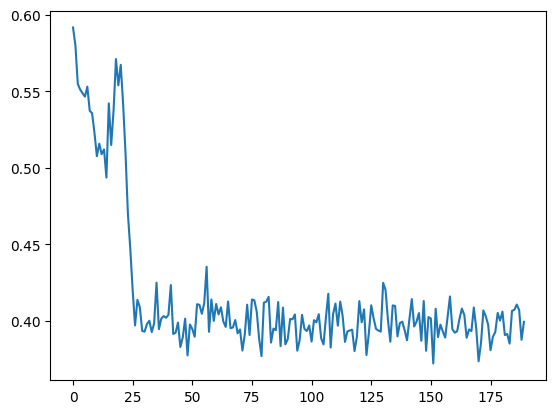

In [46]:
plt.plot(train_loss)
print(paramaters)

8.783690219615892e-09 6.368958249680645e-09 1.267986249331443e-06 1.3848336948285578e-06
0 0 0 0
3.7108796036022795e-09 1.1453747106315859e-07 2.2579699361813255e-05 2.5619303414714523e-05
0 0 0 0
3.695236827638837e-08 9.09215884803416e-08 4.404535047797253e-06 5.631636213365709e-06
0 0 0 0
5.918708578800391e-11 4.38430980409521e-09 2.756989033514401e-06 2.0504166968748905e-06
0 0 0 0
9.821592428238546e-09 3.088111100169044e-07 6.610823038499802e-05 5.6567423598608e-05
0 0 0 0
7.530893242346792e-09 2.963851386539318e-07 3.5257024137536064e-05 1.4457410543400329e-05
0 0 0 0
3.5584546420608376e-09 1.6102616484658938e-07 2.122152545780409e-05 1.7186177501571365e-05
0 0 0 0
1.4326356989613487e-08 2.1607103661835936e-08 8.512616886946489e-07 2.795535237964941e-06
0 0 0 0
4.0555913662088106e-12 1.1093388013749816e-10 4.6647491558360343e-07 7.46618411540112e-07
0 0 0 0
3.7665057184277373e-10 2.207941385279355e-08 1.2477707059588283e-05 1.0530285180720966e-05
0 0 0 0
3.8642198774141434e-07 2.0

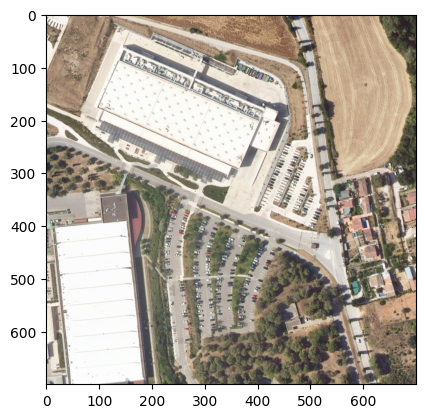

In [47]:
for images, targets in data_loader:
  images = [TF.to_tensor(image).to(device) for image in images]
  targets = [{k: v for k, v in t.items()} for t in targets]
  output = model(images)
  image = images[0].cpu().numpy()
  image = np.moveaxis(image, 0, -1)
  for bounding_box in output[0][0]:
  # for bounding_box in targets[0]["boxes"]:
    xmin, ymin, xmax, ymax = bounding_box
    print(xmin.item(), ymin.item(), xmax.item(), ymax.item())
    xmin, ymin, xmax, ymax = xmin*new_size[0], ymin*new_size[1], xmax*new_size[0], ymax*new_size[1]
    xmin, ymin, xmax, ymax = cxcywh_to_xyxy((xmin, ymin, xmax, ymax))
    print(xmin, ymin, xmax, ymax)
    cv2.rectangle(image[:, :, 1], (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
  plt.imshow(image)
  plt.show()
  break

In [48]:
output[1][0]

tensor([[0.6089],
        [0.6467],
        [0.6141],
        [0.5514],
        [0.6839],
        [0.6802],
        [0.6702],
        [0.5320],
        [0.4249],
        [0.6231],
        [0.6734],
        [0.5500],
        [0.7034],
        [0.6016],
        [0.7162],
        [0.4905],
        [0.5596],
        [0.6339],
        [0.6950],
        [0.7034],
        [0.7145],
        [0.6627],
        [0.5747],
        [0.6607],
        [0.7415],
        [0.6575],
        [0.6672],
        [0.6053],
        [0.6435],
        [0.6237],
        [0.6535],
        [0.6887],
        [0.6442],
        [0.7271],
        [0.6546],
        [0.6830],
        [0.6080],
        [0.5119],
        [0.5814],
        [0.6813],
        [0.6334],
        [0.5785],
        [0.6687],
        [0.6888],
        [0.5483],
        [0.6825],
        [0.6657],
        [0.7168],
        [0.5804],
        [0.6246],
        [0.5477],
        [0.6465],
        [0.6361],
        [0.6020],
        [0.5639],
        [0

In [ ]:
torch.save(model, "/content/drive/MyDrive/TFG_999/model.pt")

In [ ]:
model = torch.load("/content/drive/MyDrive/TFG_999/model_best.pt")

In [ ]:
for images, targets in data_loader:
  images = [TF.to_tensor(image).to(device) for image in images]
  targets = [{k: v for k, v in t.items()} for t in targets]
  output = model(images)
  print(output[0])
  print(targets[0])
  break